# under construction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as ppt
%load_ext autoreload
%autoreload 2

<h2>The "STEERABLE PYRAMID"</h2>

The steerable pyramid is a multi-scale representation that is
**translation-invariant**, but that also includes representation of
**orientation**.  Furthermore, the representation of orientation is
designed to be rotation-invariant. The basis/projection functions
are oriented (steerable) filters, localized in space and frequency.
**It is overcomplete to avoid aliasing**.  And it is "self-inverting"
(like the QMF/Wavelet transform): the projection functions and 
basis functions are identical.  The mathematical phrase for a 
transform obeying this property is "tight frame".

The system diagram for the steerable pyramid (described in the
reference given below) is as follows:<pre>
 IM ---> fhi0 -----------------> H0 ---------------- fhi0 ---> RESULT
     |                                                     |
     |                                                     |
     |-> flo0 ---> fl1/down2 --> L1 --> up2/fl1 ---> flo0 -|
               |                                 |
               |----> fb0 -----> B0 ----> fb0 ---|
               |                                 |
               |----> fb1 -----> B1 ----> fb1 ---|
               .                                 .
               .                                 .
               |----> fbK -----> BK ----> fbK ---|
</pre>
The filters {fhi0,flo0} are used to initially split the image into
a highpass residual band H0 and a lowpass subband.  This lowpass
band is then split into a low(er)pass band L1 and K+1 oriented
subbands {B0,B1,...,BK}.  The representatation is substantially
overcomplete.  The pyramid is built by recursively splitting the
lowpass band (L1) using the inner portion of the diagram (i.e.,
using the filters {fl1,fb0,fb1,...,fbK}).  The resulting transform is
overcomplete by a factor of 4k/3.

The scale tuning of the filters is constrained by the recursive
system diagram.  The orientation tuning is constrained by requiring
the property of steerability.  A set of filters form a steerable
basis if they 1) are rotated copies of each other, and 2) a copy of
the filter at any orientation may be computed as a linear
combination of the basis filters.  The simplest examples of
steerable filters is a set of N+1 Nth-order directional
derivatives.

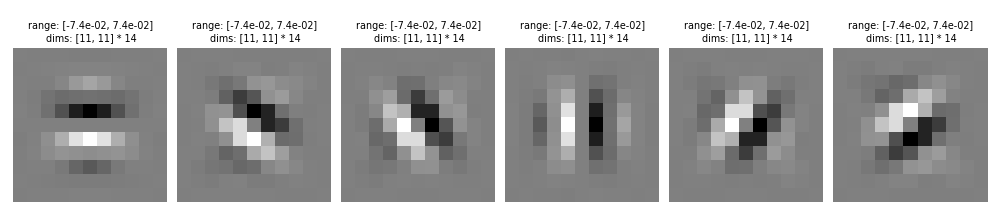

In [2]:
# Choose a filter set (options are 'sp0Filters', 'sp1Filters', 'sp3Filters', 'sp5Filters'):
filters = ppt.steerable_filters('sp5Filters')
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))
fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

ppt.imshow(filtList, vrange='auto', zoom=14, col_wrap=6);

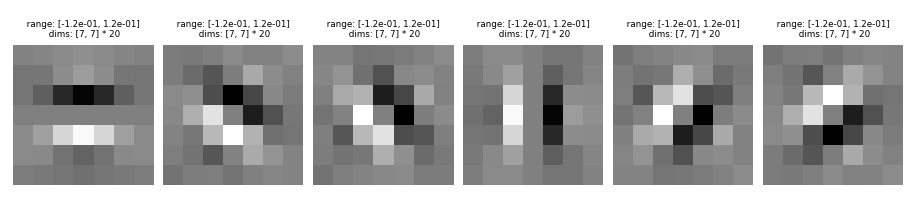

In [3]:

nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(filters['bfilts'][:,f].reshape(fsz))

ppt.imshow(filtList, vrange='auto', zoom=20, col_wrap=6);

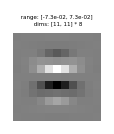

In [4]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = 180
# new_ori = 360*np.random.rand(1)[0]
ppt.imshow( sps.convolve2d( ppt.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', 8);

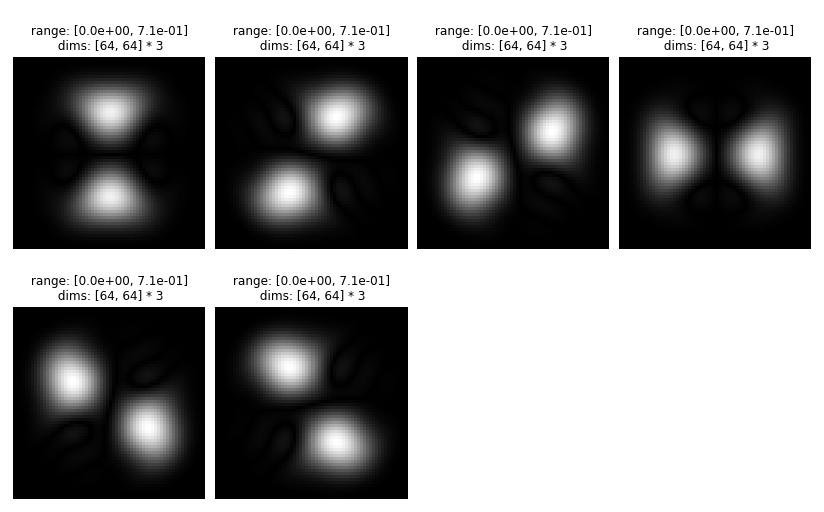

In [5]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

ppt.imshow(imgList, 'auto', zoom=3, col_wrap= 4);

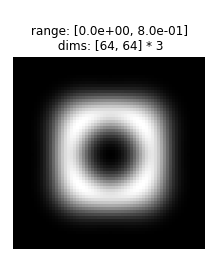

In [6]:
# The filters sum to a smooth annular ring:
ppt.imshow(fsum, 'auto', 3);

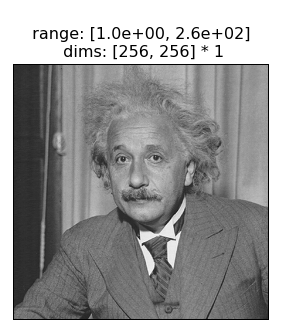

In [7]:
im = plt.imread('../DATA/einsteinCorrect.pgm')
# im = ppt.blurDn(im, 1, 'qmf9')
ppt.imshow(im);

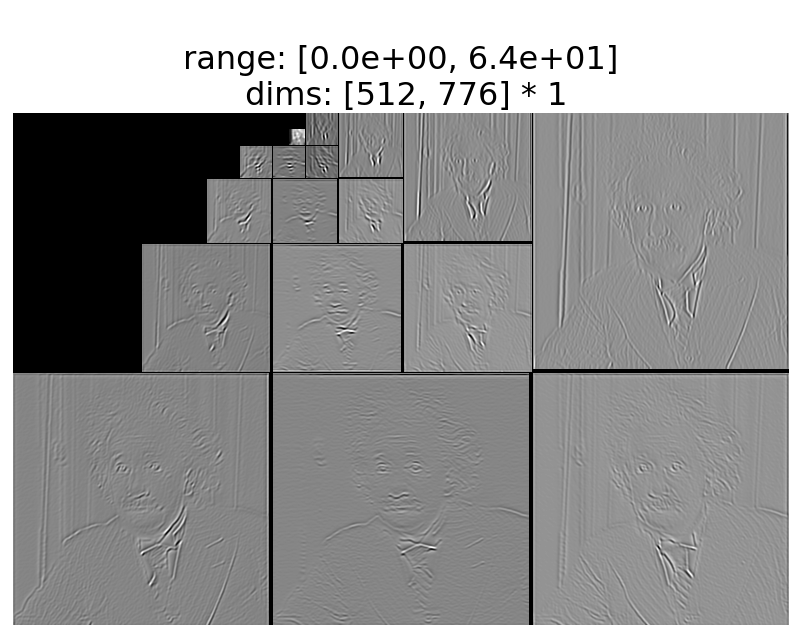

In [8]:
# build a Steerable pyramid:
pyr = ppt.SteerablePyramidSpace(im, height=4, filt='sp3Filters')
pyr.showPyr('indep1')

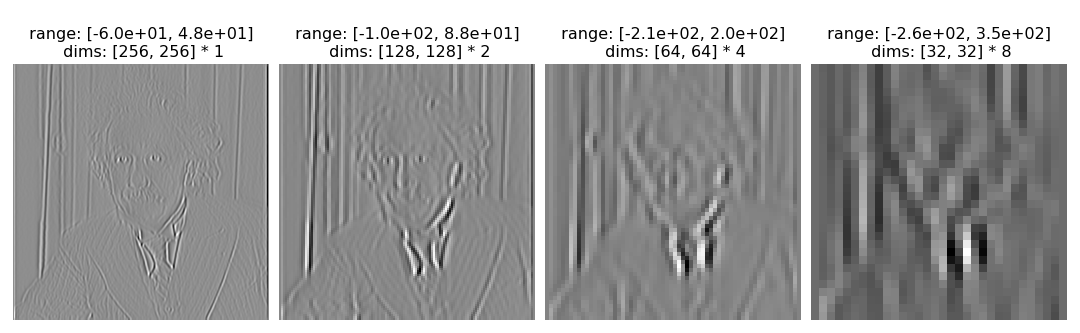

In [9]:
# Look at first (vertical) bands, different scales:
imgList = []
for s in range(pyr.spyrHt()):
    band = pyr.spyrBand(s,0)
    imgList.append(band)
ppt.imshow(imgList, col_wrap=4);

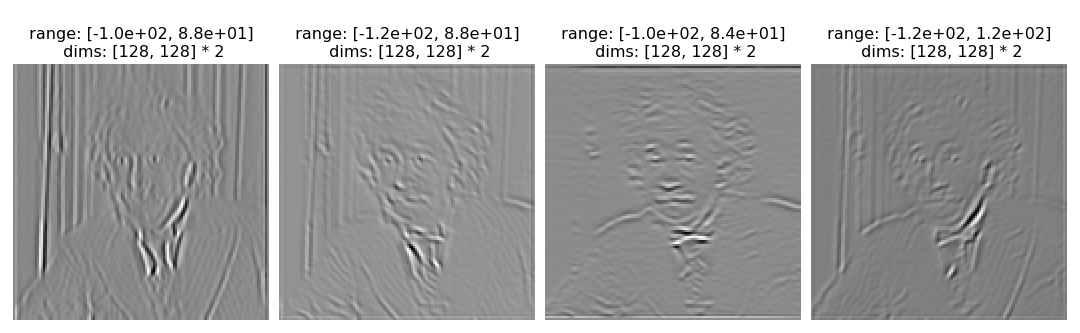

In [10]:
# look at all orientation bands at one level (scale):
imgList = []
for b in range(pyr.numBands()):
    band = pyr.spyrBand(1,b)
    imgList.append(band)

ppt.imshow(imgList, zoom=2, col_wrap=4);

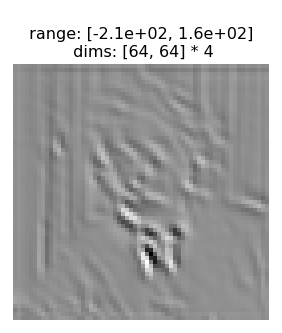

In [11]:
# look at one oriented band at one level (scale):
ppt.imshow(pyr.spyrBand(lev=2,band=1), 'auto', zoom=4);

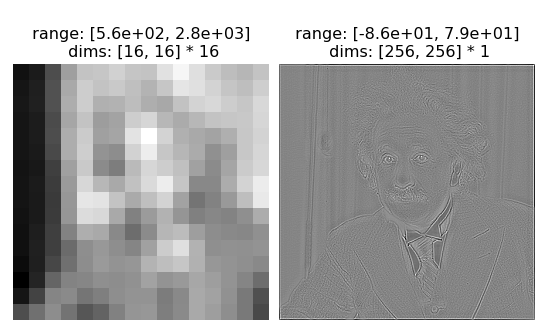

In [12]:
# To access the high-pass and low-pass bands:
low = pyr.pyrLow()
high = pyr.pyrHigh()
ppt.imshow([low, high]);

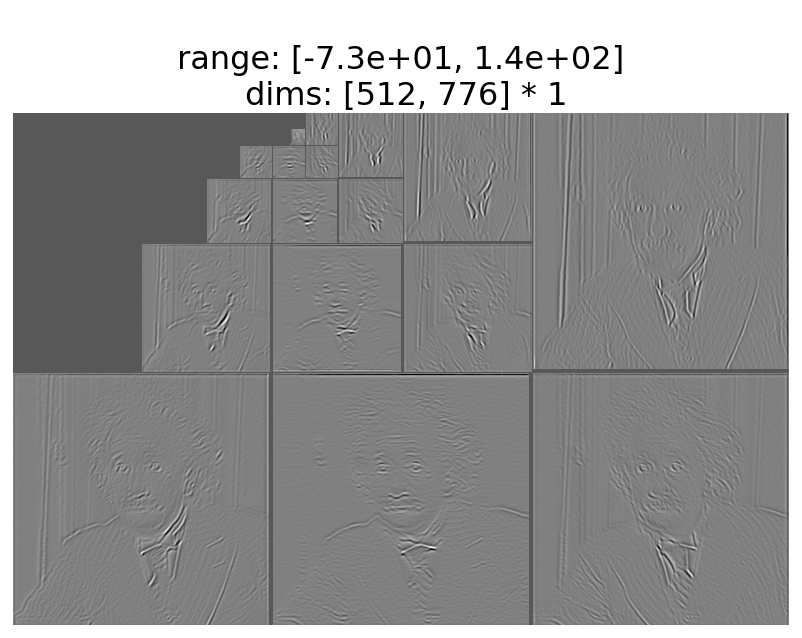

In [13]:
# Display the whole pyramid (except for the highpass residual band),
# with images shown at proper relative sizes:
pyr.showPyr()

In [14]:
# Spin a level of the pyramid, interpolating (steering to)
# intermediate orienations:
lev = pyr.spyrLev(1) # pick a scale
n = lev[0].shape[0] * lev[0].shape[1]
# create a matrix containing outputs of the pyramid in long columns
lev2 = np.concatenate((lev[0].reshape((n,1)),
                       lev[1].reshape((n,1)),
                       lev[2].reshape((n,1)),
                       lev[3].reshape((n,1))),
                      axis=1)
# lev.shape, lev2.shape

In [15]:
pySP3filt = ppt.steerable_filters('sp3Filters')
# pySP3filt

In [16]:
k = 32
M = np.empty((k, lev.shape[1], lev.shape[2]))

for frame in range(k):
    steered_im = ppt.steer(lev2, 2*np.pi*frame/16, pySP3filt['harmonics'], pySP3filt['mtx']).reshape((128,128))
    M[frame] = steered_im

In [17]:
ppt.animshow(M, 1/10)

/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display_tools.py:115: UserWarning: Ignoring dpi argument: with PyrFigure, we do not use the dpi argument for saving, use dpi_multiple instead (this is done to prevent aliasing)
  warnings.warn("Ignoring dpi argument: with PyrFigure, we do not use the dpi argument"


In [18]:
pyr.pyrSize

[(256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (256, 256),
 (128, 128),
 (128, 128),
 (128, 128),
 (128, 128),
 (64, 64),
 (64, 64),
 (64, 64),
 (64, 64),
 (32, 32),
 (32, 32),
 (32, 32),
 (32, 32),
 (16, 16)]

Difference statistics:
  Range: [-254, -19]
  Mean: -117.163779,  Stdev (rmse): 37.560320,  SNR (dB): -47.605999


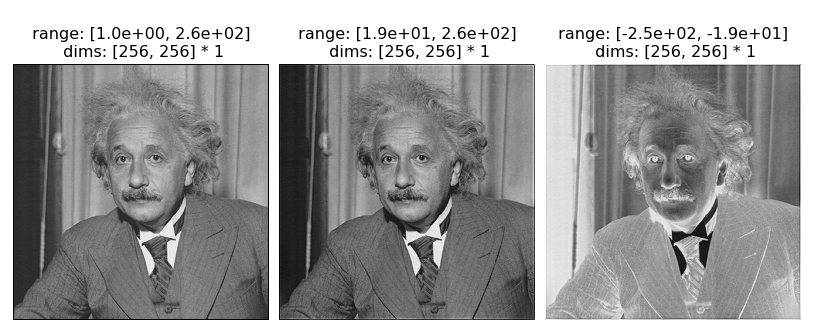

In [19]:
# Reconstruct.  Note that the filters are not perfect, although they are good
# enough for most applications.
res = pyr.reconPyr('sp3Filters')
# ppt.imshow([im, res]);
ppt.imCompare(im/255,res)

# Note that the difference lie along the boundaries
ppt.imshow([im, res, im/255 - res]);

As with previous pyramids, you can select subsets of the levels
and orientation bands to be included in the reconstruction.  For example:

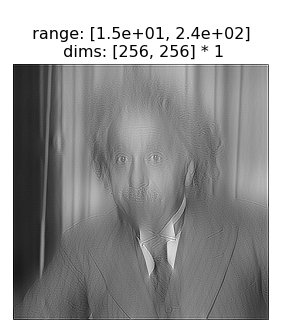

In [20]:
# All levels (including highpass and lowpass residuals), one orientation:
ppt.imshow(pyr.reconPyr('sp3Filters','reflect1','all', [0]));

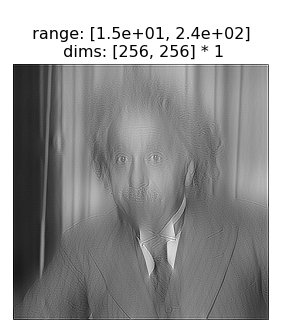

In [21]:
# Without the highpass and lowpass:
ppt.imshow(pyr.reconPyr('sp3Filters','reflect1', range(1 + pyr.spyrHt()+1), [0]));

We also provide an implementation of the Steerable pyramid in the
Frequency domain.  The advantages are perfect-reconstruction
(within floating-point error), and any number of orientation
bands.  The disadvantages are that it is typically slower, and the
boundary handling is always circular.

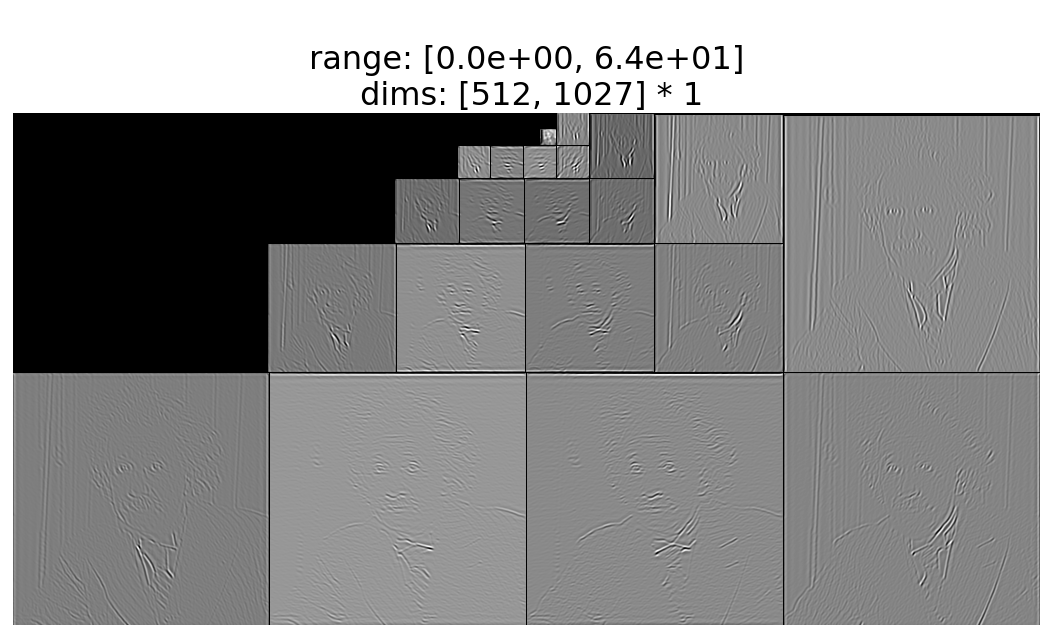

In [22]:
pyr = ppt.SteerablePyramidFreq(im,4,4)    # 4 levels, 5 orientation bands
pyr.showPyr('indep1')

In [23]:
res = pyr.reconPyr()
ppt.imCompare(im/255,res);  # nearly perfect

Difference statistics:
  Range: [-253, 0]
  Mean: -116.000079,  Stdev (rmse): 39.743047,  SNR (dB): -48.096637


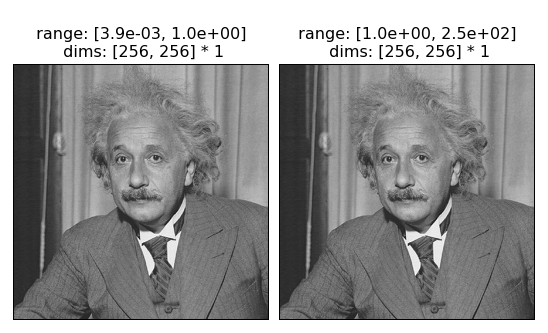

In [24]:
ppt.imshow([im/255, res]);

<h3>The steerable pyramid transform given above is described in:</h3>

E P Simoncelli and W T Freeman.<br>
The Steerable Pyramid: A Flexible Architecture for Multi-Scale 
Derivative Computation.<br>IEEE Second Int'l Conf on Image Processing.<br> 
Washington DC,  October 1995.

Online access:<br>
http://www.cns.nyu.edu/pub/eero/simoncelli95b.pdf <br>


Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 342.194542
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000001,  SNR (dB): 111.633643


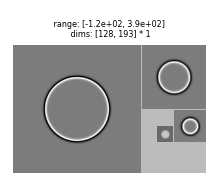

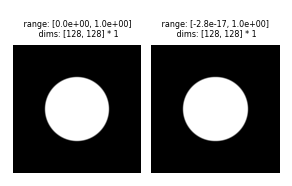

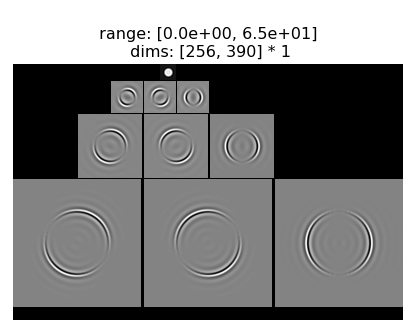

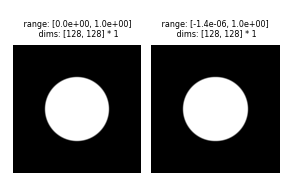

In [25]:
# reproducing Figure 4. and Figure 5. from that paper

dsk = ppt.mkDisc(128)
pyr = ppt.LaplacianPyramid(dsk,4)
pyr.showPyr()

res = pyr.reconPyr()
ppt.imCompare(dsk,res)
ppt.imshow([dsk, res]);

pyr = ppt.SteerablePyramidFreq(dsk,3,2)
pyr.showPyr(prange='indep1')

res = pyr.reconPyr()
ppt.imCompare(dsk,res)
ppt.imshow([dsk, res]);

In [26]:
# Spatial domain steerability

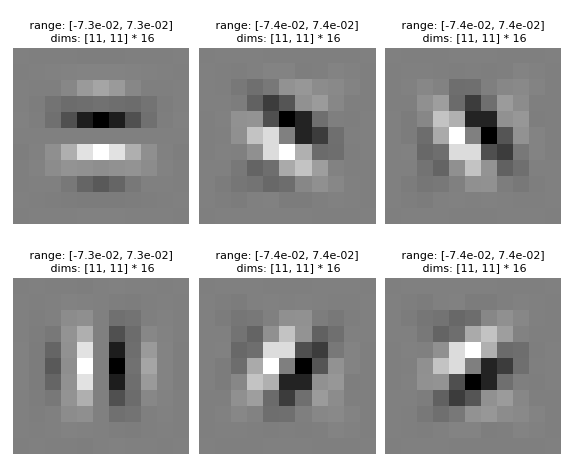

In [27]:
# Choose a filter set (options are 'sp0Filters', 'sp1Filters', 'sp3Filters', 'sp5Filters'):
filters = ppt.steerable_filters('sp5Filters')
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))

fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

ppt.imshow(filtList, zoom= 16, col_wrap= 3);

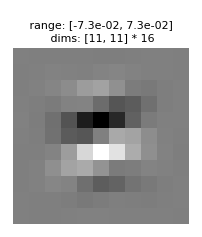

In [28]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = -12

ppt.imshow( sps.convolve2d( ppt.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', 16);

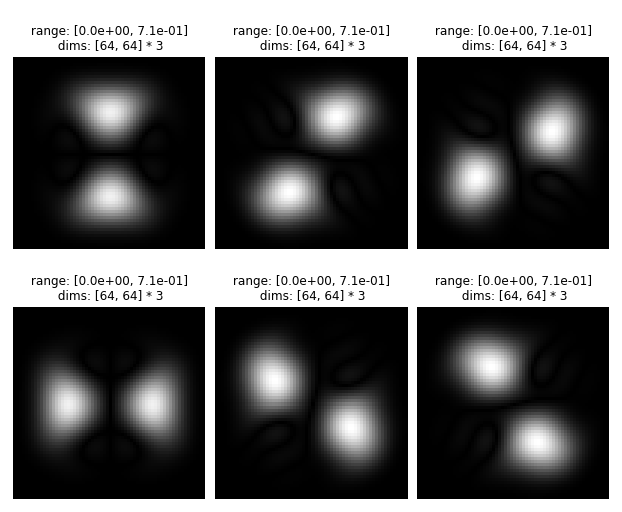

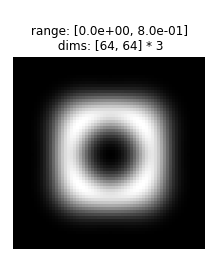

In [29]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

ppt.imshow(imgList, vrange='auto', zoom=3, col_wrap= 3)

# The filters sum to a smooth annular ring:
ppt.imshow(fsum, 'auto', 3);

In [30]:
# Looking again at the frequency domain picture

In [31]:
sz = 256
pyr = ppt.SteerablePyramidFreq(np.zeros((sz,sz)))

In [32]:
pyr.pyrSize
pyr.nbands(), len(pyr.pyr)
pyr.height
pyr.numBands()

4

In [33]:
### Put an  impulse into the middle of each band:
for lev in range(len(pyr.pyrSize)):
    mid = (pyr.pyrSize[lev][0]//2, pyr.pyrSize[lev][1]//2)
#     print(lev, mid)
    pyr.setValue(lev, mid, 1)

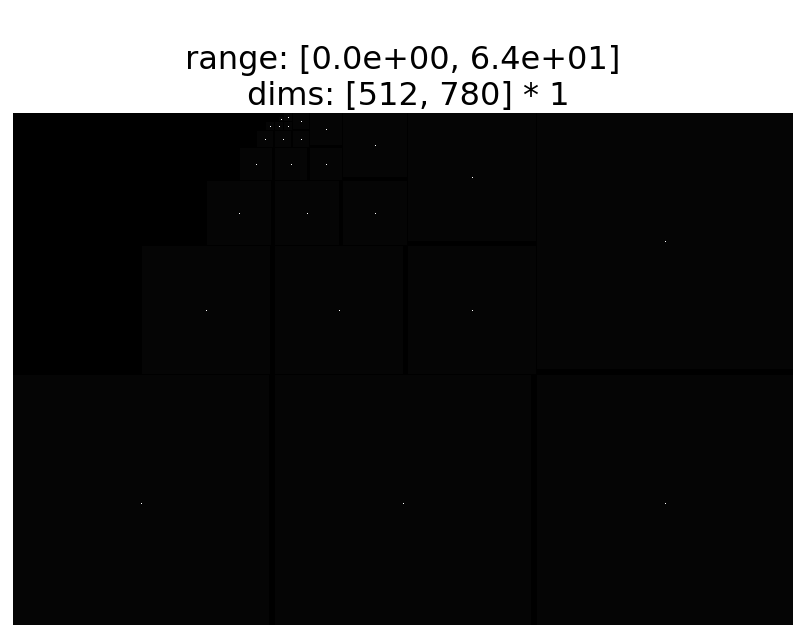

In [34]:
pyr.showPyr(prange='indep1')

In [35]:
# And take a look at the reconstruction of each band:
reconList = []
for lnum in range(int(pyr.height)):
    for bnum in range(pyr.numBands()):
        reconList.append(pyr.reconPyr([lnum], [bnum]))

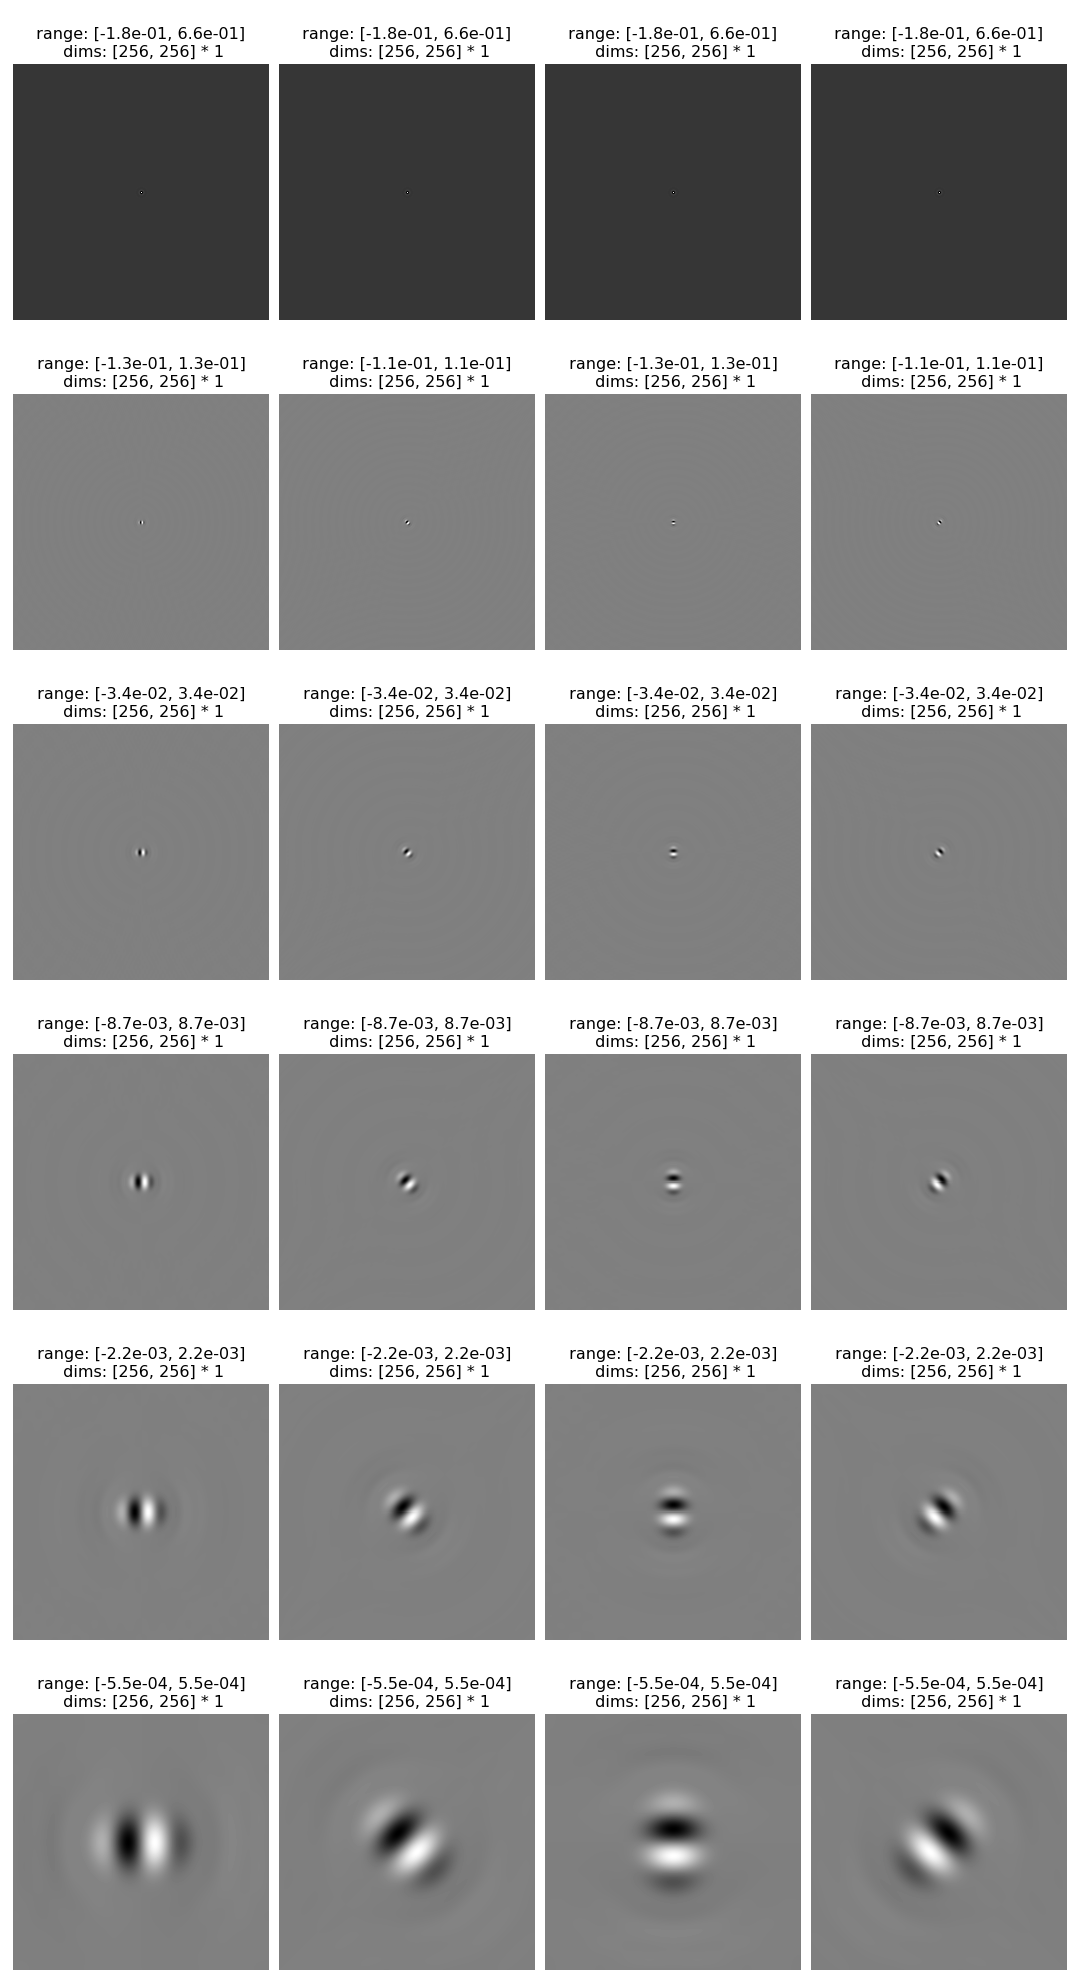

In [36]:
ppt.imshow(reconList, vrange='indep1', zoom=1, col_wrap=pyr.numBands());

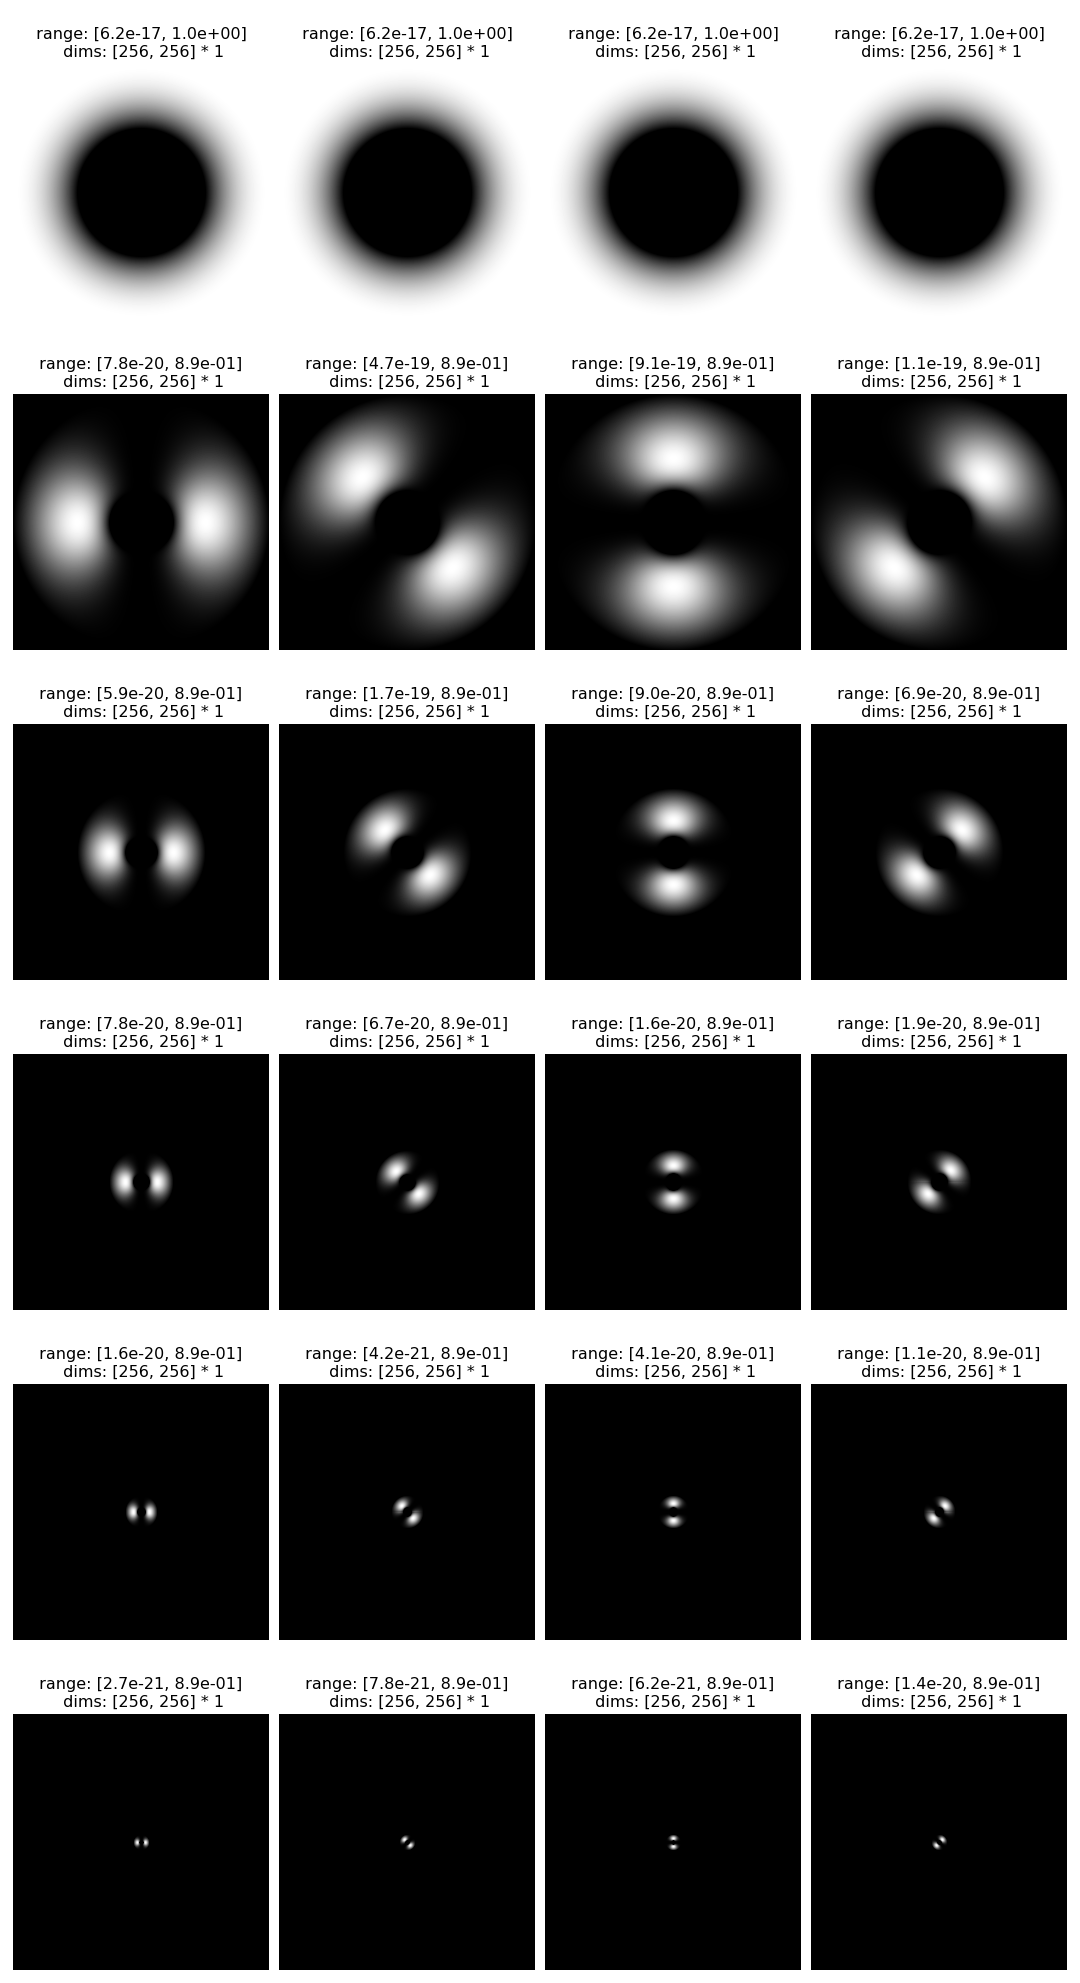

In [37]:
freq = 2 * np.pi * np.array(range(-sz//2,(sz//2)))/sz
imgList = []
for lnum in range(pyr.height):
    for bnum in range(pyr.numBands()):
        basisFn = pyr.reconPyr([lnum], [bnum])
        basisFmag = np.fft.fftshift(np.abs(np.fft.fft2(basisFn, (sz,sz))))
        imgList.append(basisFmag)

ppt.imshow(imgList, vrange='indep1', zoom=1, col_wrap=pyr.numBands());

In [38]:
# Steering the activations of a pyramid

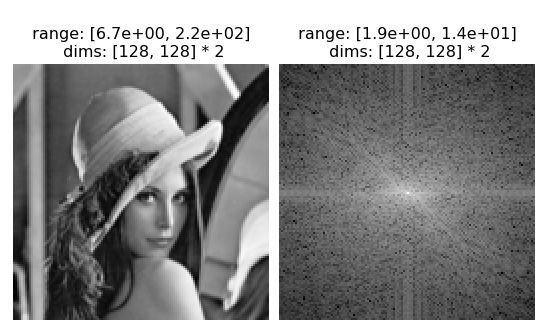

In [39]:
im = plt.imread('../DATA/lenna-256x256.tif').astype(float)

binom5 = ppt.binomialFilter(5)
lo_filt = binom5*binom5.T
im = ppt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[2, 2])

imgSize = im.shape[0]

sp = np.fft.fftshift(np.fft.fft2(im))
logfourieramplitude = np.log(np.abs(sp))
ppt.imshow([im, logfourieramplitude], vrange='indep1', zoom=2);

In [40]:
nOri = 3
pyr = ppt.SteerablePyramidFreq(im, height=1, order=nOri - 1)

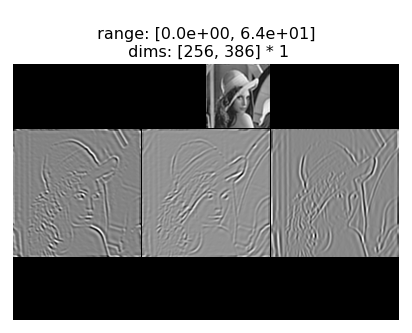

In [41]:
pyr.showPyr('indep1')

In [42]:
nOri = 5
even_phase = False

pyr = ppt.SteerablePyramidFreq(im, height=1, order=nOri - 1)

b = [pyr.pyr[i] for i in range(1, nOri + 1)]
B = np.vstack([b[i].flatten() for i in range(nOri)]).T

nSteeredOri = 100

steering_vectors = []
steered_activations = []
for i in np.linspace(-180, 180, nSteeredOri):
    bi, vi = ppt.steer(B, angle = i * np.pi / 180, return_weights=True, even_phase=even_phase)
    steering_vectors.append(vi)
    bi = bi.reshape((imgSize,imgSize))
    steered_activations.append(bi)

In [43]:
steering_vectors = np.array(steering_vectors).T
steered_activations = np.stack(steered_activations, axis=0)

In [44]:
steered_activations.shape

(100, 128, 128)

In [45]:
ppt.animshow(steered_activations)

/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display_tools.py:115: UserWarning: Ignoring dpi argument: with PyrFigure, we do not use the dpi argument for saving, use dpi_multiple instead (this is done to prevent aliasing)
  warnings.warn("Ignoring dpi argument: with PyrFigure, we do not use the dpi argument"


In [46]:
# in the frequency domain

In [47]:
steeredim_dftampl = np.zeros_like(steered_activations)
for i in range(steered_activations.shape[0]):
    steeredim_dftampl[i] = np.fft.fftshift(np.abs(np.fft.fft2((steered_activations[i]),s=(imgSize, imgSize))))

In [48]:
ppt.animshow(steeredim_dftampl)

/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display_tools.py:115: UserWarning: Ignoring dpi argument: with PyrFigure, we do not use the dpi argument for saving, use dpi_multiple instead (this is done to prevent aliasing)
  warnings.warn("Ignoring dpi argument: with PyrFigure, we do not use the dpi argument"


In [49]:
# the steering weighting vectors

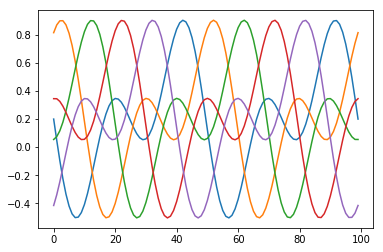

In [50]:
plt.figure()
for i in range(nOri):
    plt.plot(steering_vectors[i,:])
plt.show()

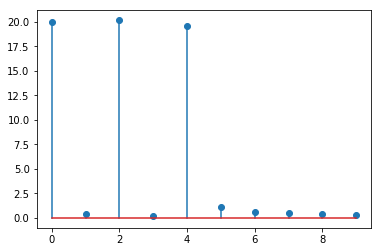

In [51]:
# expected harmonics (up to sapling error)
i = np.random.choice(nOri)
sp = np.fft.fftshift(np.fft.fft(steering_vectors[i,:]))
plt.stem(np.abs(sp)[sp.shape[0] // 2 : sp.shape[0] // 2 + nOri * 2])
plt.show()